In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [164]:
#Import song dataset
dataset = pd.read_csv('tcc_ceds_music.csv') # genres: 'pop', 'country', 'blues', 'jazz', 'reggae', 'rock', 'hip hop'
dataset['artist_name'] = dataset['artist_name'].str.lower()

#Import gender dataset, rename 'NAME' column to artist_name
gender = pd.read_csv('gender.csv')
gender['NAME'] = gender['NAME'].str.lower()
gender.rename(columns={'NAME': 'artist_name'}, inplace=True)

In [165]:
#Prepare datasets and combine them

#Re-format 'GENRE' column to list
def remove_stuff(df, column):
    to_remove = ['[',']','\n','\r',"\""," "]
    for item in to_remove:
        df[column] = df[column].str.replace(item, '')
    return df

gender_new = remove_stuff(gender, 'GENRE')
gender_new['GENRE'] = gender_new['GENRE'].str.split(',') #Convert to list, separeted indexes by comma

#Merge datasets by artist_name
combined = dataset.merge(right = gender_new, how = 'inner', on = 'artist_name')

#Filter rows where genre is in GENRE (for artists with same names but different genres)
filtered_df = combined[combined.apply(
        lambda row: any(row['genre'].lower() == g.lower() for g in row['GENRE']) if isinstance(row['GENRE'], list) else False, 
        axis=1
)]

#Drop rows with NaN values
filtered_df = filtered_df.dropna()

In [14]:
# filtered_df.columns
# Index(['Unnamed: 0', 'artist_name', 'track_name', 'release_date', 'genre',
#        'lyrics', 'len', 'dating', 'violence', 'world/life', 'night/time',
#        'shake the audience', 'family/gospel', 'romantic', 'communication',
#        'obscene', 'music', 'movement/places', 'light/visual perceptions',
#        'family/spiritual', 'like/girls', 'sadness', 'feelings', 'danceability',
#        'loudness', 'acousticness', 'instrumentalness', 'valence', 'energy',
#        'topic', 'age', 'CHARTMETRIC_ID', 'ARTIST_COUNTRY', 'PRONOUN', 'GENDER',
#        'IS_BAND', 'GENRE'],
#       dtype='object')

In [15]:
#Count of songs in each genre
filtered_df.groupby('genre').count().iloc[:,0]

genre
blues       231
country     736
jazz         87
pop        1692
reggae      161
rock       1064
Name: Unnamed: 0, dtype: int64

In [166]:
#Define numerical features
num_features = ['len', 'dating', 'violence', 'world/life', 'night/time',
       'shake the audience', 'family/gospel', 'romantic', 'communication',
       'obscene', 'music', 'movement/places', 'light/visual perceptions',
       'family/spiritual', 'like/girls','feelings', 'danceability',
       'loudness', 'acousticness', 'instrumentalness', 'valence', 'energy',
        'age']

#Define categorical features
categor = ['artist_name', 'track_name', 'genre', 'GENDER', 'topic','ARTIST_COUNTRY']

filtered = filtered_df.filter(num_features)

#Model creation and fitting
model = NearestNeighbors(n_neighbors=6,metric = 'cosine')
model.fit(filtered)

NearestNeighbors(metric='cosine', n_neighbors=6)

In [167]:
#Placeholder lists for distances later
distances_list = []
names_list = []
artist_list = []

In [168]:
import random

#Recommendation function
def recommend_songs_by_genre(user_genre, model, filtered, df, num_features, n_recommendations=50):
    #Filter
    genre_filtered_df = df[df['genre'].str.lower() == user_genre.lower()].copy()
    
    #Make sure genre exists
    if genre_filtered_df.empty:
        print(f"No songs found for the genre '{user_genre}'. Please try a different genre.")
        return None

    #Set same index
    genre_indices = genre_filtered_df.index
    filtered_genre_data = filtered.loc[genre_indices]

    #Random Song
    random_index = random.choice(genre_indices)
    
    #Get features
    input_features = filtered.loc[[random_index]]

    #Find near neighbors
    distances, indices = model.kneighbors(input_features, n_neighbors=n_recommendations + 1)

    #Add distances, names, and artists to lists for distance calculation later
    for i, index in enumerate(indices.flatten()[1:]):
        distances_list.append(distances.flatten()[i + 1])
        names_list.append(df.iloc[index]['track_name'])
        artist_list.append(df.iloc[index]['artist_name'])

    #Get index of recommendations
    recommended_indices = indices.flatten()[1:]
    
    #Return recommendations
    return df.iloc[recommended_indices][['artist_name', 'track_name', 'genre', 'GENDER']]


In [169]:
def get_recommend(user_genre):
    #Get user input
    # user_genre = input("Enter a genre: ")
    n_recommendations = 50
    
    #Get recommendations
    recommendations = recommend_songs_by_genre(user_genre, model, filtered, filtered_df, num_features, n_recommendations)
    
    if recommendations is None:
        print("Error: No recommendations found.")
        return None

    #Match up song names and distances
    dict = {'track_name':names_list, 'dist':distances_list}
    name_list_df = pd.DataFrame(dict)
    name_list_df['artist_name'] = artist_list

    num_female = 5
    num_male = 5

    #Get first n/2 recommendations male and female
    male_recommendations = recommendations[recommendations['GENDER'] == 'male'].head(num_male)
    female_recommendations = recommendations[recommendations['GENDER'] == 'female'].head(num_female)

    #Add distances to top male and female recommendations, and top 10 overall recommendations
    male_merge = male_recommendations.merge(right = name_list_df, how = 'inner', on = 'track_name')
    female_merge = female_recommendations.merge(right = name_list_df, how = 'inner', on = 'track_name')
    overall_merge = recommendations.head(10).merge(right = name_list_df, how = 'inner', on = 'track_name')

    #Calculate average distances
    male_dist = male_merge['dist'].mean()
    female_dist = female_merge['dist'].mean()
    overall_dist = overall_merge.head(10)['dist'].mean()

    #Print results
    # print(f"Male average distance: {male_dist:.6f}\nFemale average distance: {female_dist:.6f}\nOverall average distance: {overall_dist:.6f}")

    return recommendations

In [28]:
# #Get user input, generate reocmmendations
# user_genre = input("Enter a genre: ").strip()
# recommendations = recommend_songs_by_genre(user_genre, model, filtered, filtered_df, num_features)

# #Validate input
# if recommendations is not None:
#     print("\nRecommended Songs in the genre:", user_genre)
#     print(recommendations)
# else:
#     print("No recommendations found.")


In [29]:
# #Match up song names and distances
# dict = {'track_name':names_list, 'dist':distances_list}
# name_list_df = pd.DataFrame(dict)
# name_list_df['artist_name'] = artist_list

In [30]:
# #enforcing demographic parity for n=10 recommendations
# num_female = 5
# num_male = 5

# #Get first n/2 recommendations male and female
# male_recommendations = recommendations[recommendations['GENDER'] == 'male'].head(num_male)
# female_recommendations = recommendations[recommendations['GENDER'] == 'female'].head(num_female)

# #Add distances to top male and female recommendations, and top 10 overall recommendations
# male_merge = male_recommendations.merge(right = name_list_df, how = 'inner', on = 'track_name')
# female_merge = female_recommendations.merge(right = name_list_df, how = 'inner', on = 'track_name')
# overall_merge = recommendations.head(10).merge(right = name_list_df, how = 'inner', on = 'track_name')

# #Calculate average distances
# male_dist = male_merge['dist'].mean()
# female_dist = female_merge['dist'].mean()
# overall_dist = overall_merge.head(10)['dist'].mean()

# #Print results
# print(f"Male average distance: {male_dist:.6f}\nFemale average distance: {female_dist:.6f}\nOverall average distance: {overall_dist:.6f}")


GENDER \
male             2991 \
female            774 \
mixed             174 \
non-binary         13 \
androgynous         7 \
genderfluid         7 \
not specified       5 \
Name: count, dtype: int64

In [170]:
# Simulate a thousand recommendations
num_simulations = 1000
male_distances = []
female_distances = []
female_over = 0

for i in range(num_simulations):
    distances_list = []
    names_list = []
    artist_list = []

    random_genre = random.choice(filtered_df['genre'].unique())
    recommendations = get_recommend(random_genre)
    
    if recommendations is not None:
        male_recommendations = recommendations[recommendations['GENDER'] == 'male'].head(5)
        female_recommendations = recommendations[recommendations['GENDER'] == 'female'].head(5)
        
        name_dict = {'track_name':names_list, 'dist':distances_list}
        name_list_dist = pd.DataFrame(name_dict)
        name_list_dist['artist_name'] = artist_list

        male_merge = male_recommendations.merge(right=name_list_dist, how='inner', on='track_name')
        female_merge = female_recommendations.merge(right=name_list_dist, how='inner', on='track_name')

        male_distances.append(male_merge['dist'].mean())
        female_distances.append(female_merge['dist'].mean())
    
    if male_merge['dist'].mean() > female_merge['dist'].mean():
        female_over += 1


1000


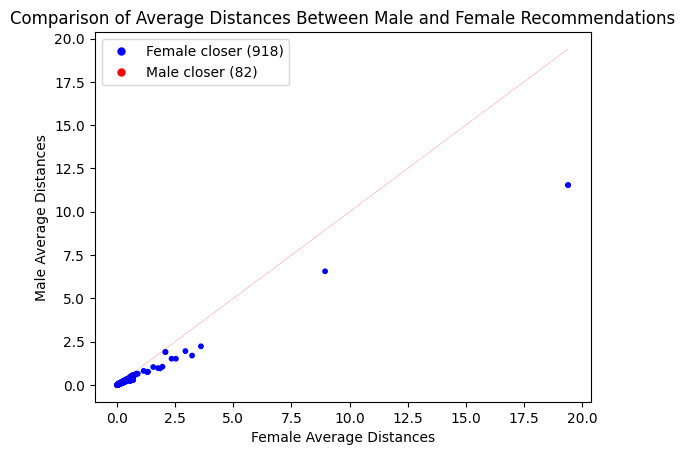

82


In [171]:
print(len(female_distances))
male_distances = [x * 1000 for x in male_distances]
female_distances = [y * 1000 for y in female_distances]

# Plot the differences between the same index average distances
colors = ['red' if male > female else 'blue' for male, female in zip(male_distances, female_distances)]
plt.scatter(female_distances, male_distances, c=colors, s=10)  # Decreased dot size
plt.xlabel('Female Average Distances')
plt.ylabel('Male Average Distances')
plt.title('Comparison of Average Distances Between Male and Female Recommendations')
plt.plot([min(female_distances), max(female_distances)], [min(female_distances), max(female_distances)], color='red', linestyle='--', linewidth=0.2)
num_blue_dots = colors.count('blue')
num_red_dots = colors.count('red')

import matplotlib.lines as mlines

# Create custom legend handles
blue_dot = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=5, label=f'Female closer ({num_blue_dots})')
red_dot = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=5, label=f'Male closer ({num_red_dots})')

plt.legend(handles=[blue_dot, red_dot], loc='upper left')
plt.show()

print(female_over)